# Basic case for error driven

In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [12]:
def evaluate_Q_at(model, y_val, solver):
    """
    Given y = y_val , minimize obj_expr and return v(y).
    This function temporarily increments the objective and clears it after completion, without changing the model structure.
    """
    # Clear any remaining As/pw/obj (to prevent it from being left over from the previous round)
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, create a temporary target and solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # check if solution okay
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)
    # clear temporarily objective
    model.del_component('obj')
    model.y.unfix()
    return v_y

def nc_underest(bounds, model_list, add_node_num, picture_shown=False, v_list=False, tolerance=1e-8):
    """
    Parameters:
        bounds (list): contains 2 float which is lower and upper bound of variable
        model (list): model with submodels corresponds to each scenario
        add_node_num (float): number of sample nodes
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    new_lb = bounds[0]
    new_ub = bounds[1]
    eff_node_count = 0 #  count how many extra nodes were actually added
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N # Storing potential new nodes
    As_min_list = []
    under_tol = 1e-8

    # set up solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-09
    solver.options['OptimalityTol'] = 1e-09
    solver.options['NonConvex'] = 2 
    
    ######### if we want to plot figures#########
    if picture_shown:
        y_vals = np.linspace(new_lb, new_ub, 100)
        Qs_vals_list = [None] * N
        for i in range(N):
            Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
        Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
        Qs_vals_sum = Qs_arr.sum(axis=0)
    #############################################
    
    # start with 2 nodes
    #y_nodes = bounds
    y_nodes = [bounds[0],bounds[1]]
    for i in range(N):
        as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('The goal is to get ',add_node_num,' nodes')
    for k in range(3,add_node_num+1):
        print('##################################################')
        print('##################################################')
        print('Start adding node ',k)
        for i in range(N):
            print(' ')
            print('Solving scenario ',i)
            # define piecewise function for each scenario
            for comp in ['obj', 'As', 'pw']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set up objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            
            if (results.solver.status != SolverStatus.ok) or \
               (results.solver.termination_condition != TerminationCondition.optimal):
                print("⚠ There may be problems with the solution")
                
            ms_list[i] = value(model_list[i].obj)
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            
            if picture_shown:
                print(' ')
                print('The plot for scenario ',i)
                print('The potential y_star is ',value(model_list[i].y))
                print('ms is ',value(model_list[i].obj))
                # set up plot parameters
                y_nodes_arr = np.array(y_nodes)
                as_nodes_arr = np.array(as_nodes_list[i])
                y_star_i = value(model_list[i].y)
                ms_i = value(model_list[i].obj)
                ## plot the figure
                plt.figure(figsize=(8, 5))
                plt.plot(y_vals, Qs_vals_list[i], label=fr'$Qs_{i}$', color='red')
                plt.plot(y_nodes_arr, as_nodes_arr+ms_i,label=fr'$As_{i} underest$',color='red', marker='o',linestyle='--',alpha=0.5)
                plt.plot(y_nodes_arr, as_nodes_arr,label=fr'$As_{i}$',color='blue', marker='o',linestyle='--',alpha=0.5)
                plt.axvline(x=y_star_i, color='purple', linestyle='--')
                plt.xlim(new_lb, new_ub)
                plt.xlabel('y')
                plt.ylabel('value')
                plt.title(fr"Plot for scenario {i} for {k} nodes")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
        ##################################################

        # define and solve the sum model
        arr = np.array(as_nodes_list, dtype=float, ndmin=2)  
        assum_nodes = arr.sum(axis=0)    
        
        model_sum = ConcreteModel()
        model_sum.y = Var(bounds=(new_lb, new_ub))
        model_sum.As = Var()
        model_sum.pw = Piecewise(
            model_sum.As, model_sum.y,
            pw_pts=y_nodes,
            f_rule=list(assum_nodes),
            pw_constr_type='EQ',
            pw_repn='SOS2'
        )
        eps_local = 1e-1
        model_sum.obj = Objective(expr = model_sum.As + eps_local*model_sum.y**2, sense=minimize)
        #model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
        results = solver.solve(model_sum)
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            pass
        else:
            print("Sum model doesn't get solved normally")
        # get the output
        As_min = results.problem.lower_bound
        y_star = value(model_sum.y, exception=False)   
        if y_star is None:
            y_star = 0.5*(new_lb + new_ub)
        errors_y_star = 0
        for i in range(N):
            errors_y_star += evaluate_Q_at(model_list[i], y_star, solver)
        errors_y_star = abs(As_min - errors_y_star)
        
        
        if picture_shown:
            print(' ')
            print('The plot for As_sum')
            print('The potential y_star is ',y_star)
            print('error is ',errors_y_star)
            # set up plot parameters
            y_nodes_arr = np.array(y_nodes)
            assum_nodes_arr = np.array(assum_nodes)
            ms_sum = sum(ms_list)
            ## plot the figure
            plt.figure(figsize=(8, 5))
            plt.plot(y_vals, Qs_vals_sum, label=fr'$Qs_sum$', color='red')
            plt.plot(y_nodes_arr, assum_nodes_arr+ms_sum,label=fr'$As_sum underest$',color='red', marker='o',linestyle='--',alpha=0.5)
            plt.plot(y_nodes_arr, assum_nodes_arr,label=fr'$As_sum$',color='blue', marker='o',linestyle='--',alpha=0.5)
            plt.axvline(x=y_star, color='purple', linestyle='--')
            plt.xlim(new_lb, new_ub)
            plt.xlabel('y')
            plt.ylabel('value')
            plt.title(fr"Plot for As_sum for {k} nodes")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        sum_ms = abs(sum(ms_i for ms_i in ms_list))
        
        print('*****************************************')
        print('error at y_star is ',errors_y_star)
        print('y_star is ',y_star)
        print('ms_list and sum_ms is ',ms_list,sum_ms)
        if errors_y_star > sum_ms:
            new_node = y_star
            print('new node choosen from error')
        else:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            print('new node choosen from ms')
        print('new node is',new_node)
        print('*****************************************')
        print('')
        As_min_list.append(As_min+sum_ms)
        #######################################################              

        if (new_node not in y_nodes) and (k != add_node_num):
            idx = bisect.bisect_left(y_nodes, new_node)
            y_nodes.insert(idx, new_node)
            for i in range(N):
                as_nodes_list[i].insert(idx, evaluate_Q_at(model_list[i], new_node, solver))
            eff_node_count += 1
                


    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    output_lb = results.problem.lower_bound + sum(ms_list)
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    return delta, output_lb, y_nodes, [range(3,add_node_num+1), As_min_list]

The goal is to get  5  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -1.0
ms is  0.0


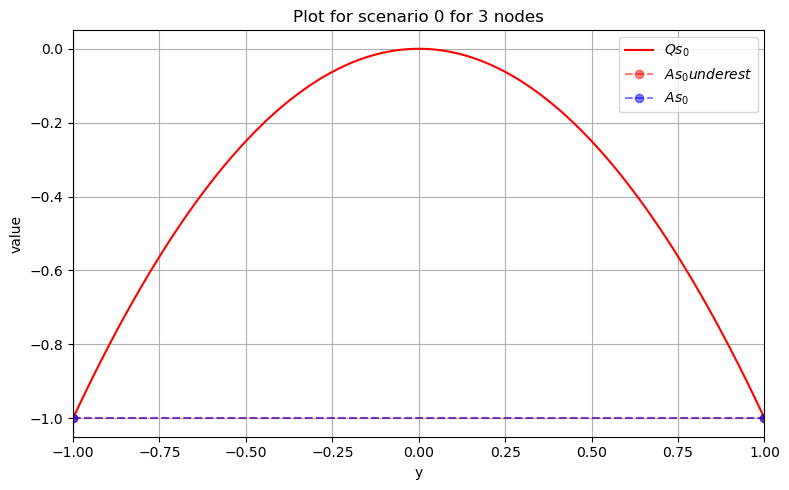

 
The plot for As_sum
The potential y_star is  -0.0
error is  1.0


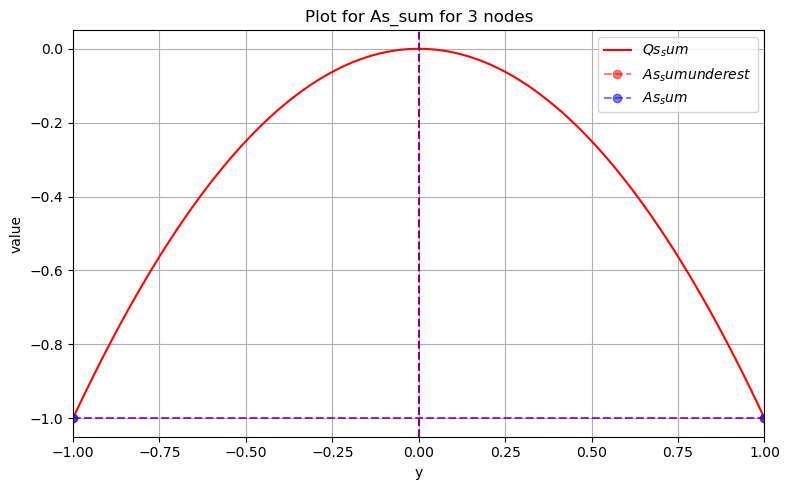

*****************************************
error at y_star is  1.0
y_star is  -0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from error
new node is -0.0
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.0
ms is  0.0


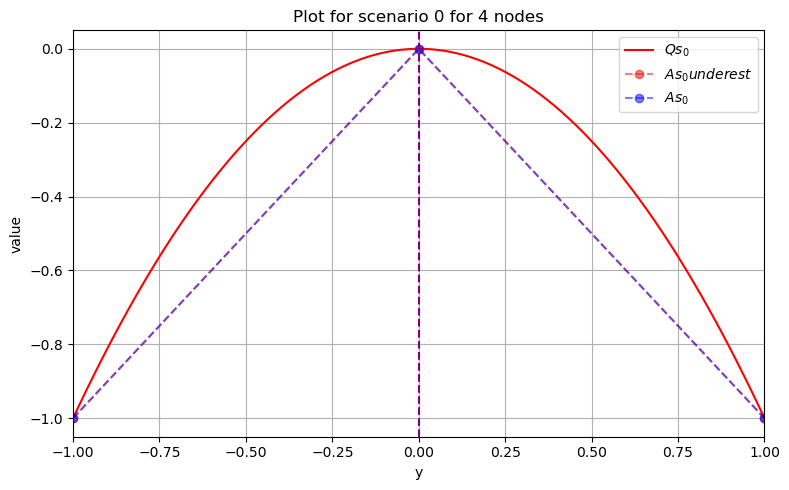

 
The plot for As_sum
The potential y_star is  -1.0
error is  0.09999999999999998


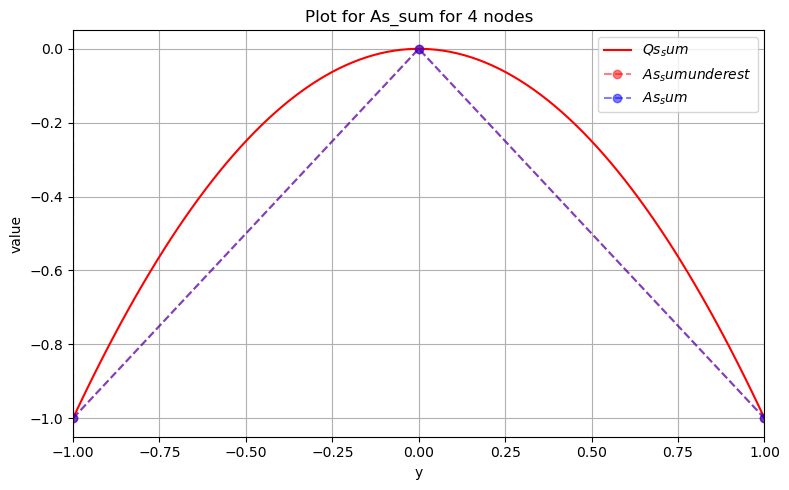

*****************************************
error at y_star is  0.09999999999999998
y_star is  -1.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from error
new node is -1.0
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.0
ms is  0.0


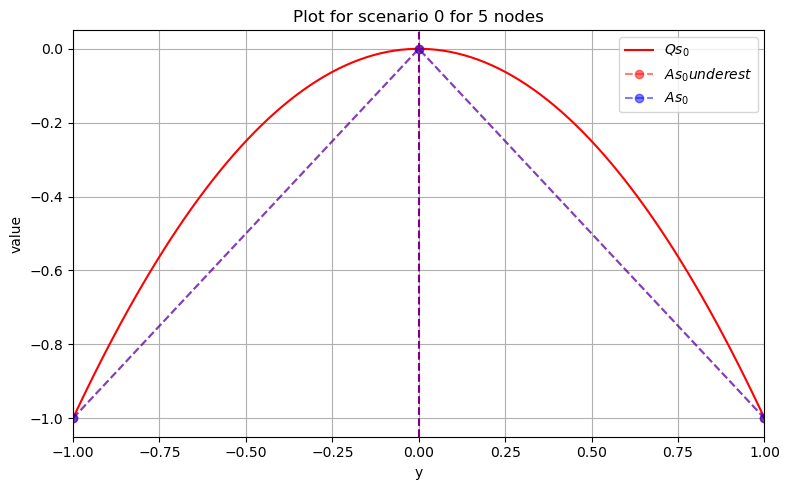

 
The plot for As_sum
The potential y_star is  -1.0
error is  0.09999999999999998


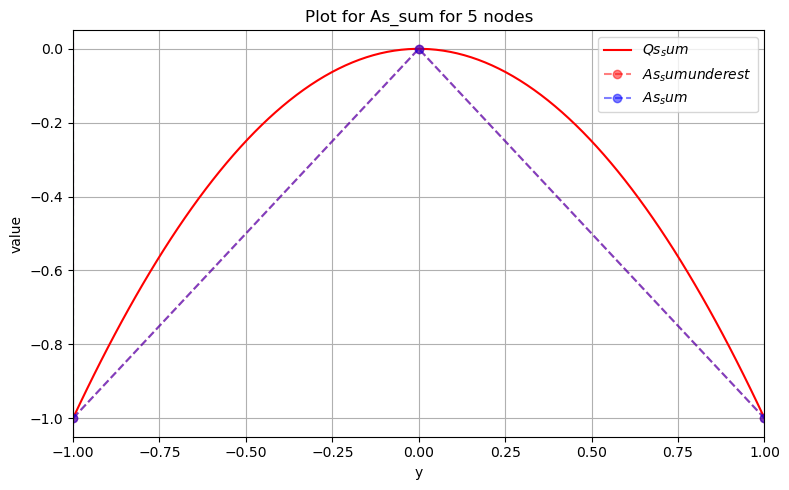

*****************************************
error at y_star is  0.09999999999999998
y_star is  -1.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from error
new node is -1.0
*****************************************



In [13]:
# build function for each scenario
def v_1(y):  
    return -y**2

v_list = [v_1]

# lower bound and upper bound
ylb = -1
yub = 1
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=-m1.x1)

model_list = [m1]
# make delta list
result = nc_underest([ylb, yub],model_list,5,True, v_list)

# Another case

The goal is to get  8  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  1.0032051282051282
ms is  -1.5624587768040592


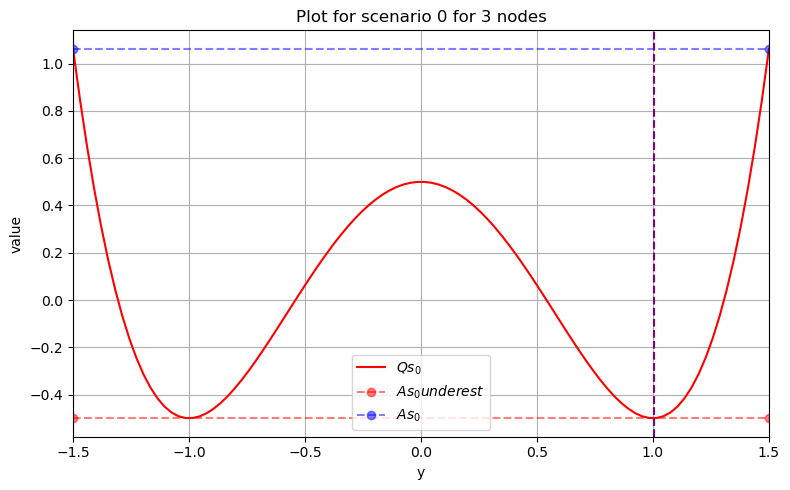

 
The plot for As_sum
The potential y_star is  -0.0
error is  0.5625


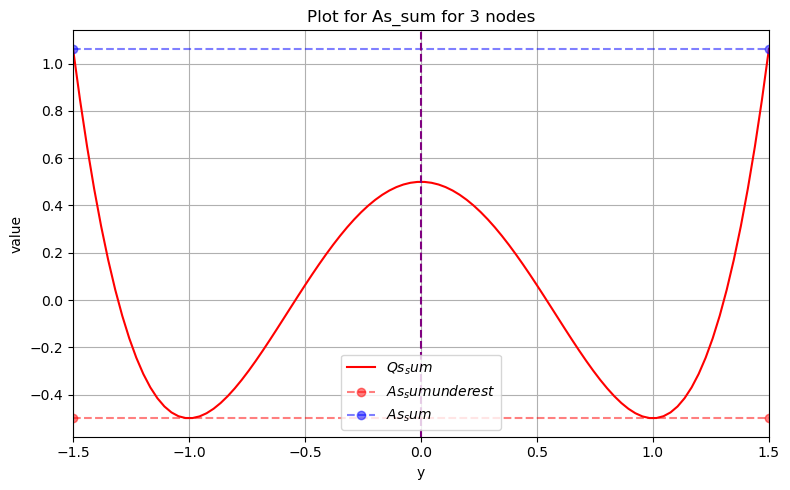

*****************************************
error at y_star is  0.5625
y_star is  -0.0
ms_list and sum_ms is  [-1.5624587768040592] 1.5624587768040592
new node choosen from ms
new node is 1.0032051282051282
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -1.0704116623829767
ms is  -1.2731060072217177


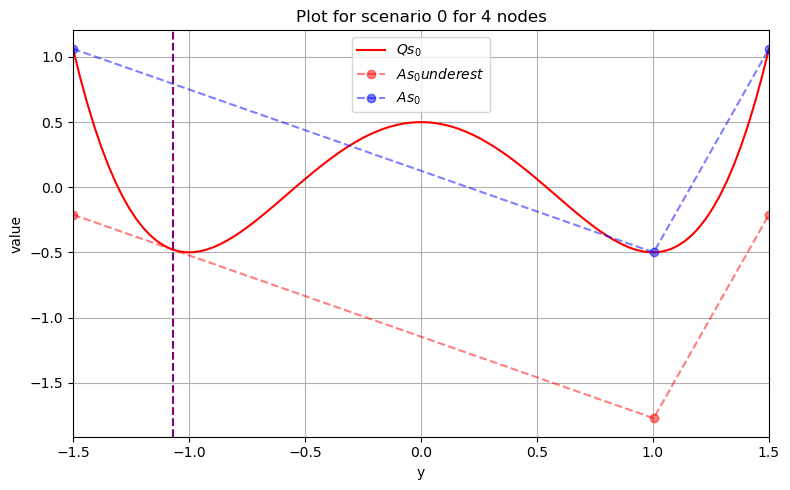

 
The plot for As_sum
The potential y_star is  1.0032051282051282
error is  0.10064205292570677


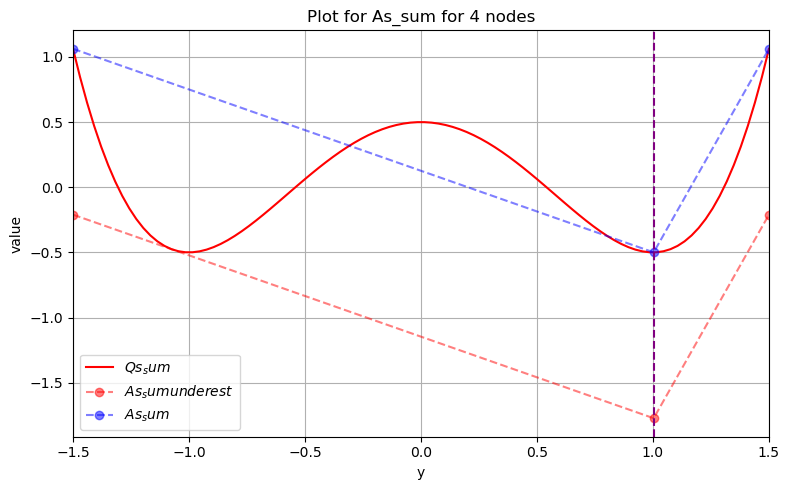

*****************************************
error at y_star is  0.10064205292570677
y_star is  1.0032051282051282
ms_list and sum_ms is  [-1.2731060072217177] 1.2731060072217177
new node choosen from ms
new node is -1.0704116623829767
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  1.2720460834773755
ms is  -0.4635179408437191


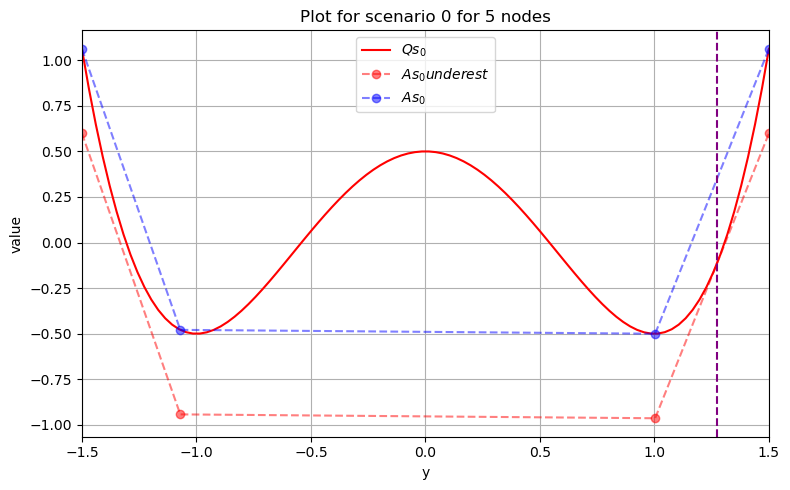

 
The plot for As_sum
The potential y_star is  0.051144729054231494
error is  0.9847338999437525


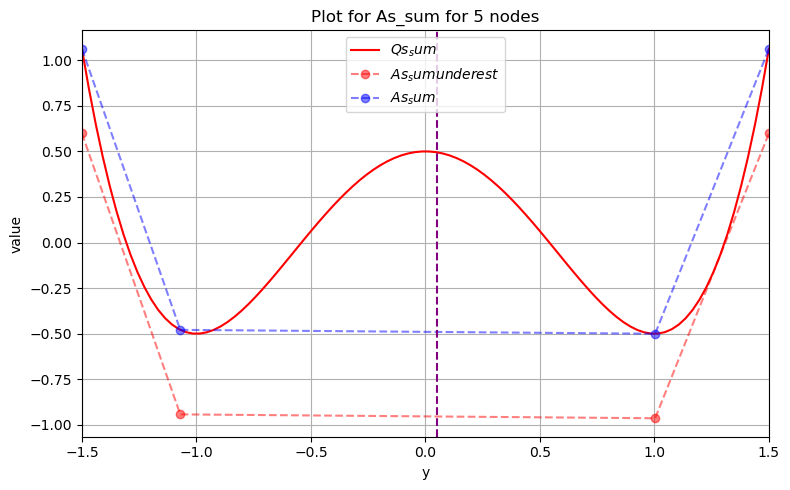

*****************************************
error at y_star is  0.9847338999437525
y_star is  0.051144729054231494
ms_list and sum_ms is  [-0.4635179408437191] 0.4635179408437191
new node choosen from error
new node is 0.051144729054231494
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  1.2734527962140634
ms is  -0.4635027635291397


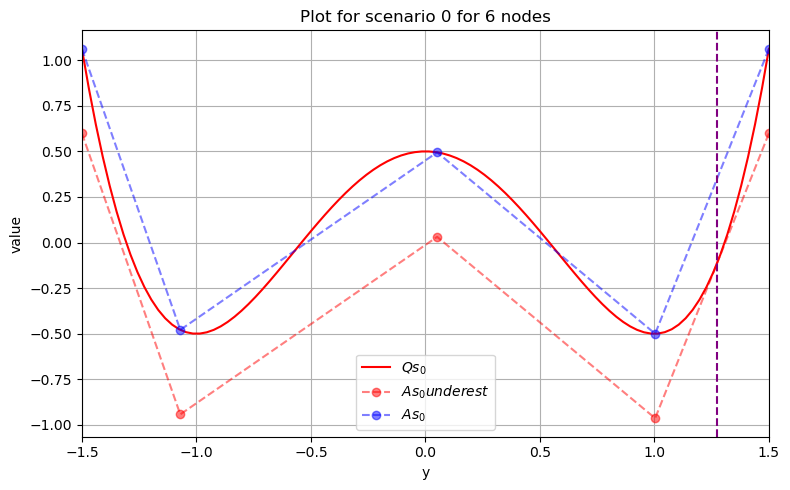

 
The plot for As_sum
The potential y_star is  1.0032051282051337
error is  0.10064205292570483


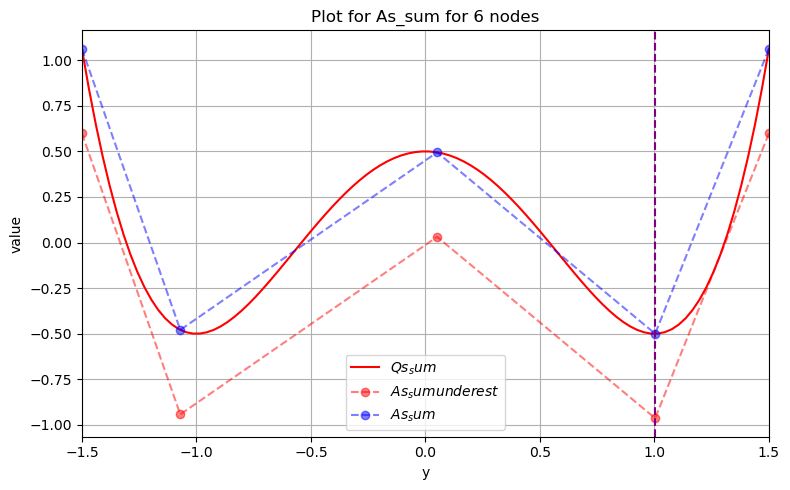

*****************************************
error at y_star is  0.10064205292570483
y_star is  1.0032051282051337
ms_list and sum_ms is  [-0.4635027635291397] 0.4635027635291397
new node choosen from ms
new node is 1.2734527962140634
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -1.299983543129783
ms is  -0.3688535848272615


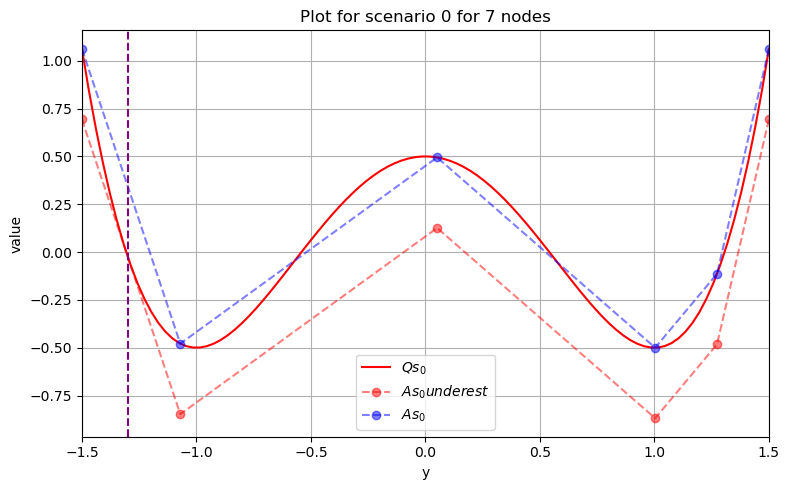

 
The plot for As_sum
The potential y_star is  1.0032051282051282
error is  0.10064205292570677


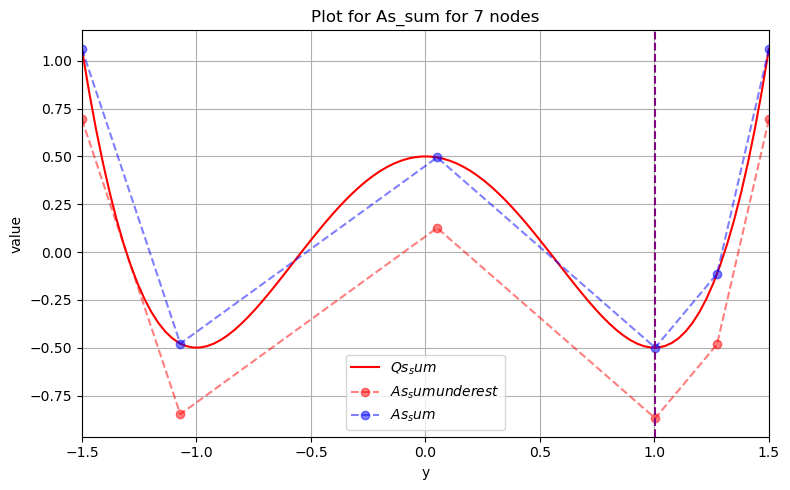

*****************************************
error at y_star is  0.10064205292570677
y_star is  1.0032051282051282
ms_list and sum_ms is  [-0.3688535848272615] 0.3688535848272615
new node choosen from ms
new node is -1.299983543129783
*****************************************

##################################################
##################################################
Start adding node  8
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.8661555018102503
ms is  -0.1361613304288612


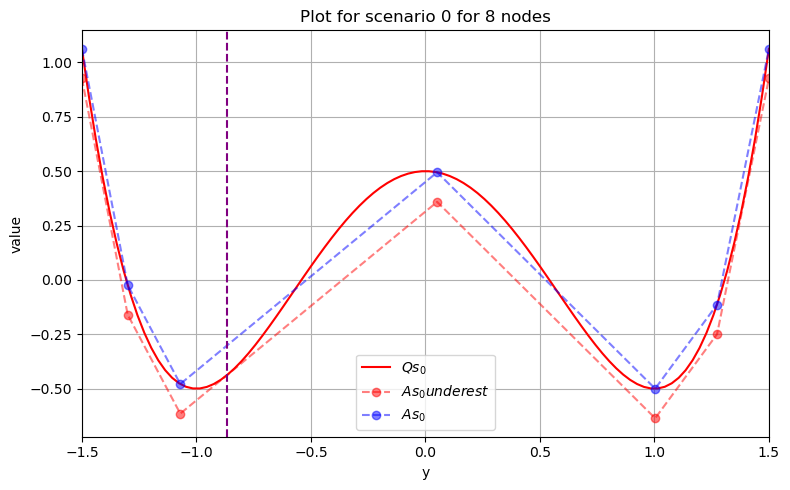

 
The plot for As_sum
The potential y_star is  1.0032051282051282
error is  0.10064205292570677


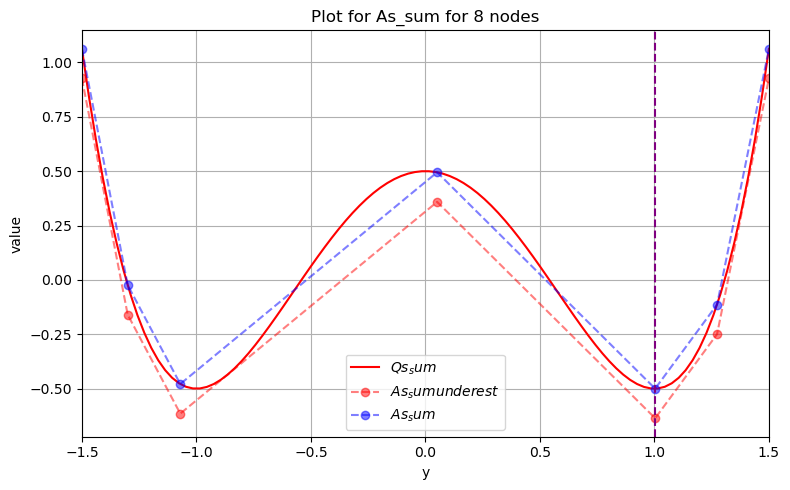

*****************************************
error at y_star is  0.10064205292570677
y_star is  1.0032051282051282
ms_list and sum_ms is  [-0.1361613304288612] 0.1361613304288612
new node choosen from ms
new node is -0.8661555018102503
*****************************************



In [14]:
# build function for each scenario
def v_1(y):  
    return (y**2-1)**2-1/2

v_list = [v_1]

# lower bound and upper bound
ylb = -1.5
yub = 1.5
bounds = [ylb, yub]
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=(m1.x1-1)**2-1/2)

model_list = [m1]
result = nc_underest([ylb, yub],model_list,8,True, v_list)

In [27]:
d_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5]
e_list = []
for d in d_list:
    result = nc_underest([-d, d],model_list,30,False, v_list)
    e_list.append(-result[1])

WARNING (W1002): Setting Var 'y' to a numeric value `-1` outside the bounds
(-1e-05, 1e-05).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'y' to a numeric value `1` outside the bounds
(-1e-05, 1e-05).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
The goal is to get  30  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
*****************************************
error at y_star is  0.5
y_star is  0.0
ms_list and sum_ms is  [-0.5] 0.5
new node choosen from ms
new node is -0.0
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.125] 0.125
new node choosen from ms
new node is

##################################################
##################################################
Start adding node  25
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.001953125
new node choosen from ms
new node is -0.6875
*****************************************

##################################################
##################################################
Start adding node  26
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.001953125
new node choosen from ms
new node is 0.6875
*****************************************

##################################################
##################################################
Start adding node  27
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.0019

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.9531249999999584e-05] 1.9531249999999584e-05
new node choosen from ms
new node is -0.09375000000000004
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.9531250000000017e-05] 1.9531250000000017e-05
new node choosen from ms
new node is 0.08125000000000006
*****************************************

##################################################
##################################################
Start adding node  20
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953125000000045e-05] 1.953125000000045e-05
new node choosen from ms
new node is 0.09375000000

##################################################
##################################################
Start adding node  12
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-7.81250000000002e-07] 7.81250000000002e-07
new node choosen from ms
new node is 0.008749999999999999
*****************************************

##################################################
##################################################
Start adding node  13
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-7.812500000000004e-07] 7.812500000000004e-07
new node choosen from ms
new node is -0.0037500000000000003
*****************************************

##################################################
##################################################
Start adding node  14
 
Solving scenario  0
*****************************************
error at y_star 

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.25e-07] 1.25e-07
new node choosen from ms
new node is 0.0005
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-3.1249999999999965e-08] 3.1249999999999965e-08
new node choosen from ms
new node is -0.00075
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-3.125e-08] 3.125e-08
new node choosen from ms
new node is 0.00025
*****************************************

#########################################

##################################################
##################################################
Start adding node  27
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953125e-09] 1.953125e-09
new node choosen from ms
new node is 6.25e-05
*****************************************

##################################################
##################################################
Start adding node  28
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953124999999998e-09] 1.953124999999998e-09
new node choosen from ms
new node is -0.0001875
*****************************************

##################################################
##################################################
Start adding node  29
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_m

*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##################################################
Start adding node  22
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##################################################
Start adding node  23
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##########################################

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding node  18
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding

C:\Users\pc\AppData\Local\Temp\ipykernel_116288\4161946405.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(d_list), np.log(e_list), color='red')
C:\Users\pc\AppData\Local\Temp\ipykernel_116288\4161946405.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(d_list), np.log(e_list), color='red')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


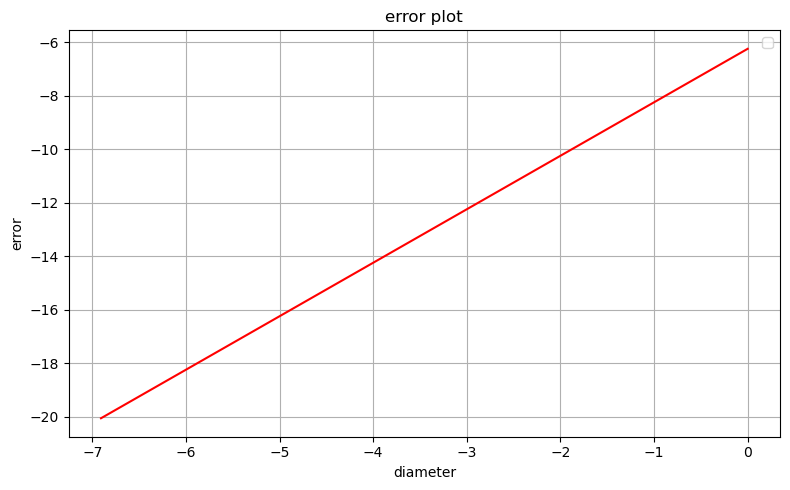

  diameter     errors
----------------------
         1 0.0019531250000000
       0.1 0.0000195312500000
      0.01 0.0000001953125000
     0.001 0.0000000019531250
    0.0001 -0.0000000012500000
     1e-05 -0.0000000000000000


In [29]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(d_list), np.log(e_list), color='red')
plt.xlabel('diameter')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'diameter':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(d_list, e_list):
    print(f"{a:>10} {e:>10.16f}")

In [19]:
# build function for each scenario
def v_1(y):  
    return 0.5*y**2

v_list = [v_1, v_1]

# lower bound and upper bound
ylb = -1
yub = 1
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=0.5*m1.x1)

model_list = [m1,m1]
# make delta list
adds = np.arange(3, 30)
results = [nc_underest([ylb, yub],model_list,a) for a in adds]

##################################################
##################################################
The goal is to get  3  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, 1]
##################################################
##################################################
The goal is to get  4  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, -0.0, 1]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is -0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.0, 1]
##################################################
#######################################

ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 0.5, 1]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is -0.75
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.5, 1]
Start adding node  7
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is 0.25
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.25, 0.5, 1]
Start adding node  8
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is 0.75
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.25, 0.5, 0.75, 1]
Start adding node  9
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
n

Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is -0.25
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.25, -0.0, 0.25, 0.5, 0.75, 1]
Start adding node  10
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is -0.875
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.25, -0.0, 0.25, 0.5, 0.75, 1]
Start adding node  11
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 0.625
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.25, -0.0, 0.25, 0.5, 0.625, 0.75, 1]
Start adding node  12
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 

Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 0.125
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
##################################################
##################################################
The goal is to get  16  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, -0.0, 1]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is -0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 1]
Start adding node  5
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen 

ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  17
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is -0.625
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
##################################################
##################################################
The goal is to get  18  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, -0.0, 1]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is -

Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is -0.125
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  15
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 0.125
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  16
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 0.375
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  17
Solving scenario  0
Solving scenari

 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is 0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 0.5, 1]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is -0.75
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.5, 1]
Start adding node  7
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is 0.25
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.25, 0.5, 1]
Start adding node  8
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is 0.75
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.25, 0.5, 0.75, 1]
Start adding node  9
Solving scenario  0
Solving sce

ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.0, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  14
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is -0.125
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  15
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 0.125
ms list is [-0.0078125, -0.0078125]
y_nodes is [-1, -0.875, -0.75, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
Start adding node  16
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0078125, -0.0078125] 0.015625
 
 
new node choosen from ms
 
new node is 0.375
ms list is [-0.0078125, -0.0078125]
y

Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is 0.8124999999999999
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.75, -0.625, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.8124999999999999, 0.875, 1]
Start adding node  20
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is 0.9375
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.75, -0.625, -0.5, -0.375, -0.25, -0.125, -0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
Start adding node  21
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is -0.0625
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375

Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is -0.8125
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.8125, -0.75, -0.625, -0.5, -0.375, -0.25, -0.125, -0.0625, -0.0, 0.0625, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
Start adding node  24
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is 0.1875
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.8125, -0.75, -0.625, -0.5, -0.375, -0.25, -0.125, -0.0625, -0.0, 0.0625, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
##################################################
##################################################
The goal is to get  25  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  

##################################################
##################################################
The goal is to get  26  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, -0.0, 1]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is -0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 1]
Start adding node  5
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is 0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 0.5, 1]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is -0.75
ms list is 

Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, -0.0, 1]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is -0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 1]
Start adding node  5
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is 0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 0.5, 1]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is -0.75
ms list is [-0.03125, -0.03125]
y_nodes is [-1, -0.75, -0.5, -0.0, 0.5, 1]
Start adding node  7
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.0312

##################################################
##################################################
The goal is to get  28  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node is -0.0
ms list is [-0.5, -0.5]
y_nodes is [-1, -0.0, 1]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is -0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 1]
Start adding node  5
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.125, -0.125] 0.25
 
 
new node choosen from ms
 
new node is 0.5
ms list is [-0.125, -0.125]
y_nodes is [-1, -0.5, -0.0, 0.5, 1]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.03125, -0.03125] 0.0625
 
 
new node choosen from ms
 
new node is -0.75
ms list is 

ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.8125, -0.75, -0.6875, -0.625, -0.5, -0.375, -0.3125, -0.25, -0.125, -0.0625, -0.0, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.5, 0.625, 0.6875, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
Start adding node  28
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is -0.5625
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.8125, -0.75, -0.6875, -0.625, -0.5, -0.375, -0.3125, -0.25, -0.125, -0.0625, -0.0, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.5, 0.625, 0.6875, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
##################################################
##################################################
The goal is to get  29  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  1.0
y_star is  0.0
ms is  [-0.5, -0.5] 1.0
 
 
new node choosen from ms
 
new node

Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is 0.6875
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.8125, -0.75, -0.6875, -0.625, -0.5, -0.375, -0.25, -0.125, -0.0625, -0.0, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.5, 0.625, 0.6875, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
Start adding node  27
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
new node choosen from ms
 
new node is -0.3125
ms list is [-0.001953125, -0.001953125]
y_nodes is [-1, -0.9375, -0.875, -0.8125, -0.75, -0.6875, -0.625, -0.5, -0.375, -0.3125, -0.25, -0.125, -0.0625, -0.0, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.5, 0.625, 0.6875, 0.75, 0.8124999999999999, 0.875, 0.9375, 1]
Start adding node  28
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.0
ms is  [-0.001953125, -0.001953125] 0.00390625
 
 
ne

   
   
   
y node is  [-1  1]
y node length 2
ms value is  [-0.5, -0.5]
new_nodes is  -0.0
this time choose scenario  0


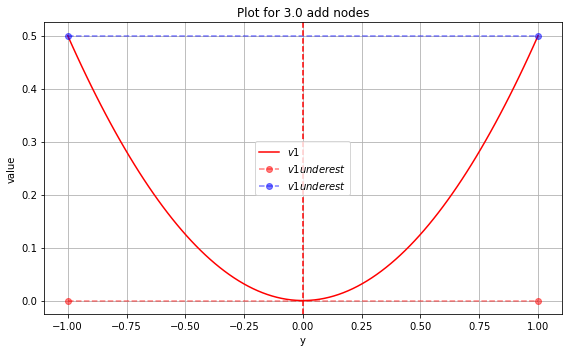

   
   
   
y node is  [-1. -0.  1.]
y node length 3
ms value is  [-0.125, -0.125]
new_nodes is  -0.5
this time choose scenario  1


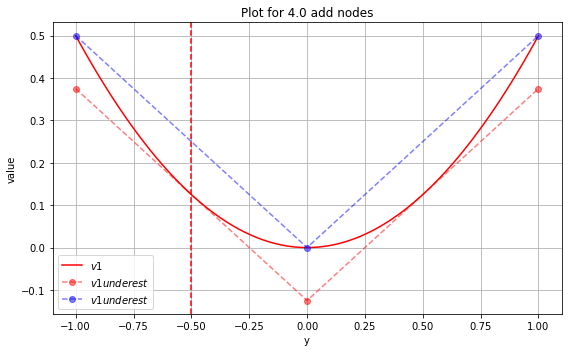

   
   
   
y node is  [-1.  -0.5 -0.   1. ]
y node length 4
ms value is  [-0.125, -0.125]
new_nodes is  0.5
this time choose scenario  2


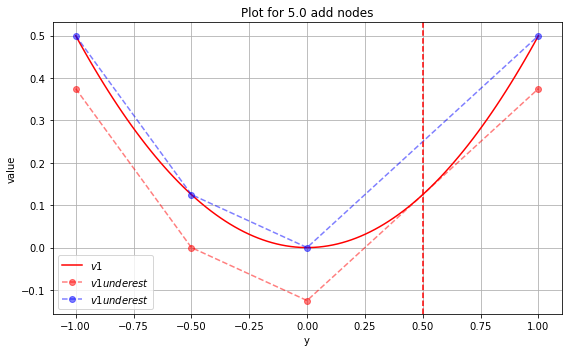

   
   
   
y node is  [-1.  -0.5 -0.   0.5  1. ]
y node length 5
ms value is  [-0.03125, -0.03125]
new_nodes is  -0.75
this time choose scenario  3


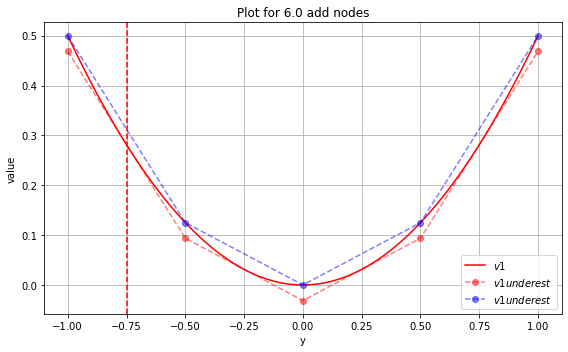

   
   
   
y node is  [-1.   -0.75 -0.5  -0.    0.5   1.  ]
y node length 6
ms value is  [-0.03125, -0.03125]
new_nodes is  0.25
this time choose scenario  4


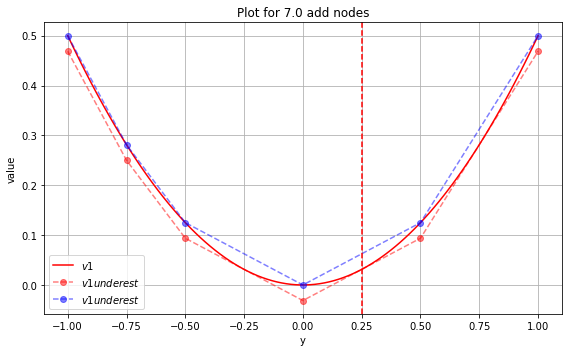

   
   
   
y node is  [-1.   -0.75 -0.5  -0.    0.25  0.5   1.  ]
y node length 7
ms value is  [-0.03125, -0.03125]
new_nodes is  0.75
this time choose scenario  5


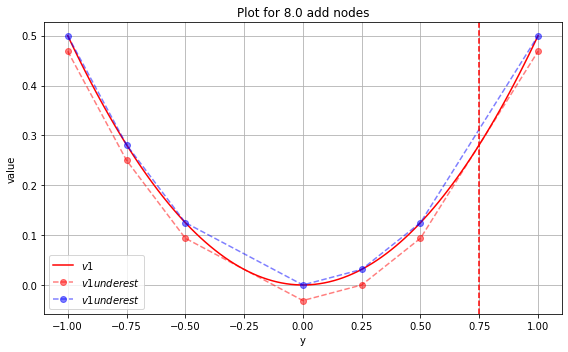

   
   
   
y node is  [-1.   -0.75 -0.5  -0.    0.25  0.5   0.75  1.  ]
y node length 8
ms value is  [-0.03125, -0.03125]
new_nodes is  -0.25
this time choose scenario  6


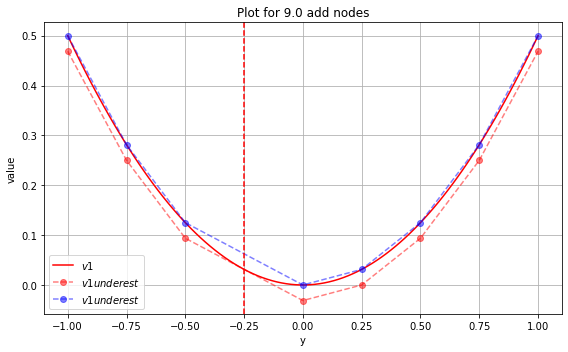

In [16]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.0, 0.25, 0.25, 0.0625, 0.0625, 0.0625, 0.0625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625]


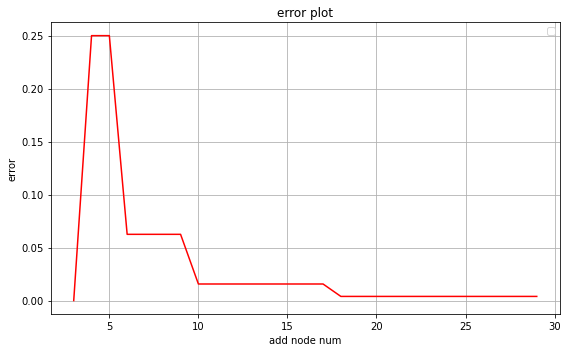

In [20]:
true_lb = 0
plt.figure(figsize=(8, 5))
errors = [true_lb-item[1] for item in results]
plt.plot(adds, errors, color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

In [5]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return -(y-1)**2+1

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(0, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(0, 1))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == -(m2.y-1)**2)
m2.obj_expr = Expression(expr=m2.x2+1)

model_list = [m1, m2]
# lower bound and upper bound
ylb = 0
yub = 0.2
# make delta list
adds = np.arange(3, 9)
results = [nc_underest([ylb, yub],model_list,a) for a in adds]

##################################################
##################################################
The goal is to get  3  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.2
ms is  [-0.1118033988749895, 0.0] 0.1118033988749895
 
 
new node choosen from ms
 
new node is 0.05
ms list is [-0.1118033988749895, 0.0]
y_nodes is [0, 0.2]
##################################################
##################################################
The goal is to get  4  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.2
ms is  [-0.1118033988749895, 0.0] 0.1118033988749895
 
 
new node choosen from ms
 
new node is 0.05
ms list is [-0.1118033988749895, 0.0]
y_nodes is [0, 0.05, 0.2]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  0.0
y_star is  0.05
ms is  [-0.055901699437494755, 0.0] 0.055901699437494755
 
 
new node choosen from ms
 
new node is 0.012500000000000004
ms list is

   
   
   
y node is  [0.  0.2]
y node length 2
ms value is  [-0.1118033988749895, 0.0]
new_nodes is  0.05
this time choose scenario  0


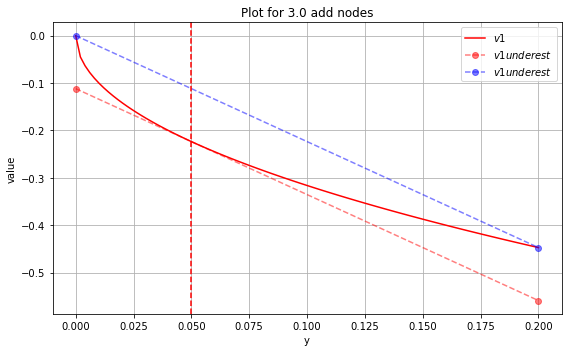

   
   
   
y node is  [0.   0.05 0.2 ]
y node length 3
ms value is  [-0.055901699437494755, 0.0]
new_nodes is  0.012500000000000004
this time choose scenario  1


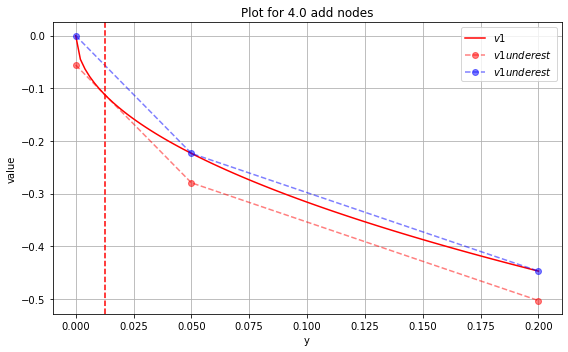

   
   
   
y node is  [0.     0.0125 0.05   0.2   ]
y node length 4
ms value is  [-0.02795084971874737, 1.4777196133408665e-10]
new_nodes is  0.003125
this time choose scenario  2


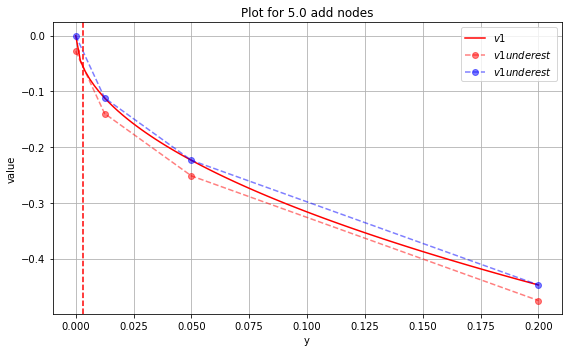

   
   
   
y node is  [0.       0.003125 0.0125   0.05     0.2     ]
y node length 5
ms value is  [-0.018633794998004216, 1.4234799450285607e-10]
new_nodes is  0.1123221932051504
this time choose scenario  3


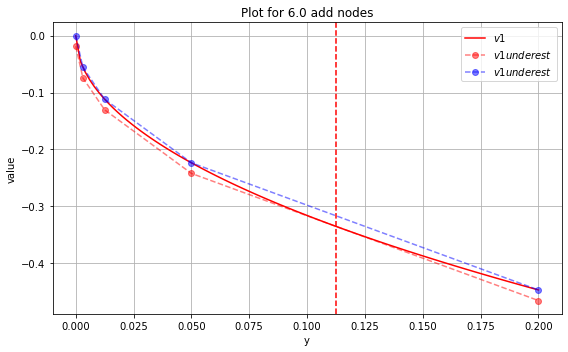

   
   
   
y node is  [0.         0.003125   0.0125     0.05       0.11232219 0.2       ]
y node length 6
ms value is  [-0.013975424859373689, 1.2212453270876722e-15]
new_nodes is  0.0007812500000000002
this time choose scenario  4


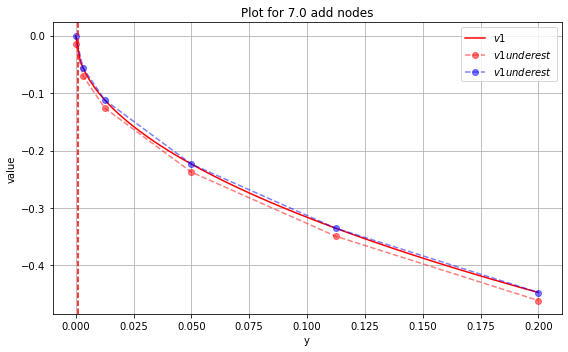

   
   
   
y node is  [0.         0.00078125 0.003125   0.0125     0.05       0.11232219
 0.2       ]
y node length 7
ms value is  [-0.009316768550690746, 1.1102230246251565e-16]
new_nodes is  0.02820778450493551
this time choose scenario  5


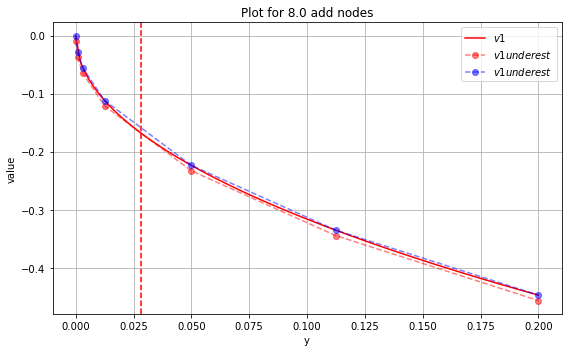

In [6]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.06950048274177548, 0.05249198555430162, 0.024541135687782212, 0.015224080972463139, 0.010565710976179338, 0.005907054667497497, 0.0035779985464935993, 0.0021566113411781995, 0.004508283124798257, 0.003863107553982892, 0.003343688821124985, 0.0026671248474866016, 0.0021790434269022274, 0.0018274727521843115, 0.0015985658162092908, 0.0013952262866864795, 0.0012479651871966646]


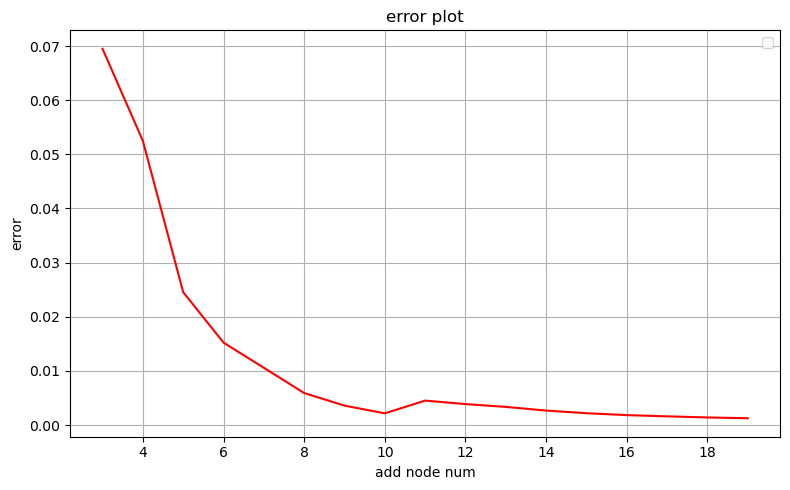

In [84]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, errors, color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

In [75]:
m = ConcreteModel()
m.y = Var(bounds=(0, 1))
m.x1 = Var(bounds=(0, 1))
m.x11 = Var(bounds=(0, None))
m.x2 = Var()
m.c1 = Constraint(expr=m.x11**2 == m.y**2)
m.c2 = Constraint(expr=m.x11 == (m.x1)**2)
m.c3 = Constraint(expr=m.x2 == -(m.y-1)**2)
m.obj = Objective(expr=-m.x1+m.x2+1, sense=minimize)

In [76]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [77]:
results = solver.solve(m)
mmm = results.problem.lower_bound

In [78]:
mmm

-0.12951651163317207

In [65]:
# build function for each scenario
def v_1(y):  
    return (y**2-1)**2-1/2

def v_2(y): 
    return (y**2-1)**2-1/2
v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -1.5
yub = 1.5
bounds = [ylb, yub]
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=(m1.x1-1)**2-1/2)

m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=(m1.x1-1)**2-1/2)

model_list = [m1,m1]

In [71]:
# make delta list
adds = np.arange(3, 15)

results = [nc_underest([ylb, yub],model_list,a) for a in adds]

##################################################
##################################################
The goal is to get  3  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  4.000000000670134e-08
y_star is  0.2
ms is  [-0.1118033988749895, 0.0] 0.1118033988749895
 
 
new node choosen from ms
 
new node is 0.05
ms list is [-0.1118033988749895, 0.0]
y_nodes is [0, 0.2]
##################################################
##################################################
The goal is to get  4  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  4.000000000670134e-08
y_star is  0.2
ms is  [-0.1118033988749895, 0.0] 0.1118033988749895
 
 
new node choosen from ms
 
new node is 0.05
ms list is [-0.1118033988749895, 0.0]
y_nodes is [0, 0.05, 0.2]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  2.4999997072505664e-09
y_star is  0.05
ms is  [-0.055901699437494755, 0.0] 0.055901699437494755
 
 
new node choose

Solving scenario  1
 
 
error is  2.4999997072505664e-09
y_star is  0.05
ms is  [-0.055901699437494755, 0.0] 0.055901699437494755
 
 
new node choosen from ms
 
new node is 0.012500000000000004
ms list is [-0.055901699437494755, 0.0]
y_nodes is [0, 0.012500000000000004, 0.05, 0.2]
Start adding node  5
Solving scenario  0
Solving scenario  1
 
 
error is  2.500000012561898e-09
y_star is  0.05
ms is  [-0.02795084971874737, 1.477720307230257e-10] 0.02795084957097534
 
 
new node choosen from ms
 
new node is 0.003125
ms list is [-0.02795084971874737, 1.477720307230257e-10]
y_nodes is [0, 0.003125, 0.012500000000000004, 0.05, 0.2]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  2.500000012561898e-09
y_star is  0.05
ms is  [-0.01863379499800427, 1.4234799450285607e-10] 0.018633794855656277
 
 
new node choosen from ms
 
new node is 0.11232219320515047
ms list is [-0.01863379499800427, 1.4234799450285607e-10]
y_nodes is [0, 0.003125, 0.012500000000000004, 0.05, 0.1

Solving scenario  1
 
 
error is  2.500000012561898e-09
y_star is  0.05
ms is  [-0.005566325224371449, 1.1102230246251565e-16] 0.005566325224371338
 
 
new node choosen from ms
 
new node is 0.07804604580240435
ms list is [-0.005566325224371449, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
Start adding node  11
Solving scenario  0
Solving scenario  1
 
 
error is  6.091185278389588e-09
y_star is  0.07804604580240435
ms is  [-0.004658477174458525, 1.1102230246251565e-16] 0.004658477174458414
 
 
new node choosen from ms
 
new node is 0.0070323940366497995
ms list is [-0.004658477174458525, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
##################################################
############

ms list is [-0.005566325224371449, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
Start adding node  11
Solving scenario  0
Solving scenario  1
 
 
error is  6.091185278389588e-09
y_star is  0.07804604580240435
ms is  [-0.004658477174458525, 1.1102230246251565e-16] 0.004658477174458414
 
 
new node choosen from ms
 
new node is 0.0070323940366497995
ms list is [-0.004658477174458525, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.0070323940366497995, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
Start adding node  12
Solving scenario  0
Solving scenario  1
 
 
error is  6.091185278389588e-09
y_star is  0.07804604580240435
ms is  [-0.004013301603643049, 0.0] 0.004013301603643049
 
 
new node choosen from ms
 
new node is 0.15302007337131376
ms

   
   
   
y node is  [-1.5  1.5]
y node length 2
ms value is  [-1.5624587768040592, -1.5624587768040592]
new_nodes is  1.0032051282051282
this time choose scenario  0


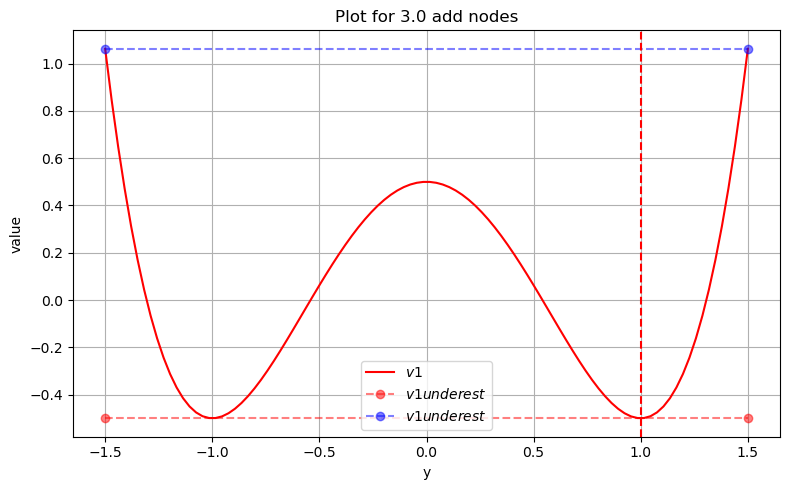

   
   
   
y node is  [-1.5         1.00320513  1.5       ]
y node length 3
ms value is  [-1.2731060072217177, -1.2731060072217177]
new_nodes is  -1.0704116623829767
this time choose scenario  1


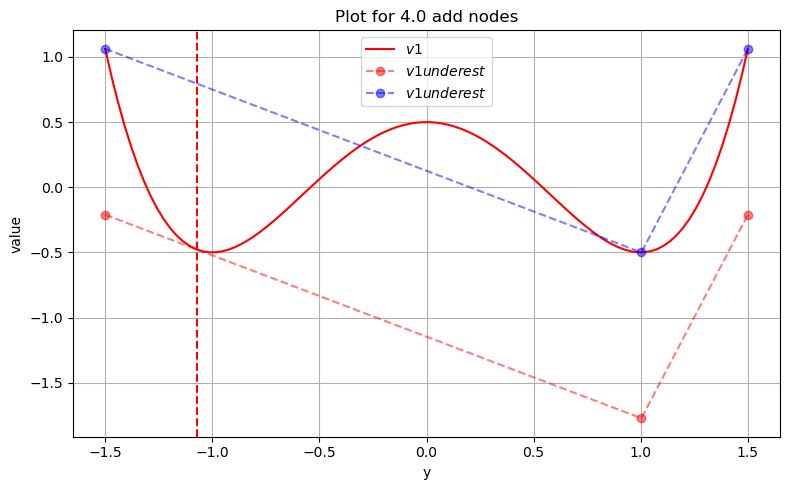

   
   
   
y node is  [-1.5        -1.07041166  1.00320513  1.5       ]
y node length 4
ms value is  [-0.4635179408437191, -0.4635179408437191]
new_nodes is  1.2720460834773755
this time choose scenario  2


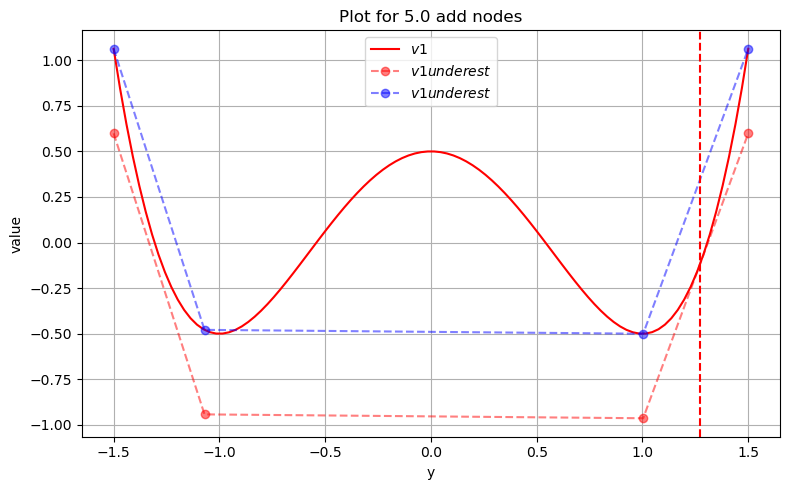

   
   
   
y node is  [-1.5        -1.07041166  1.00320513  1.27204608  1.5       ]
y node length 5
ms value is  [-0.3688535848272618, -0.3688535848272618]
new_nodes is  -1.299983543129783
this time choose scenario  3


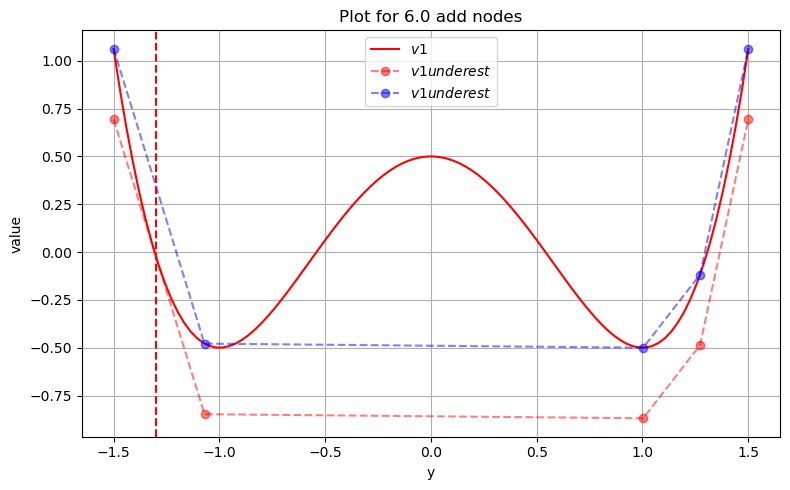

   
   
   
y node is  [-1.5        -1.29998354 -1.07041166  1.00320513  1.27204608  1.5       ]
y node length 6
ms value is  [-0.12405911052166413, -0.12405911052166413]
new_nodes is  1.3897923308291613
this time choose scenario  4


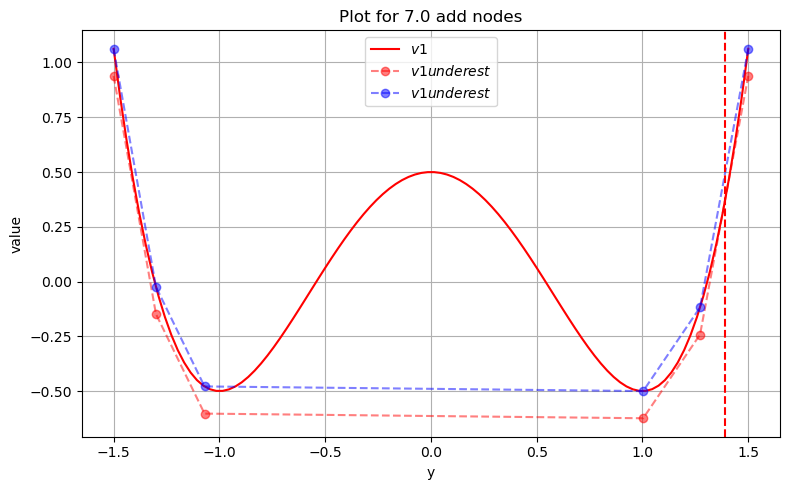

   
   
   
y node is  [-1.5        -1.29998354 -1.07041166  1.00320513  1.27204608  1.38979233
  1.5       ]
y node length 7
ms value is  [-0.10478768641310399, -0.10478768641310399]
new_nodes is  1.144578316257184
this time choose scenario  5


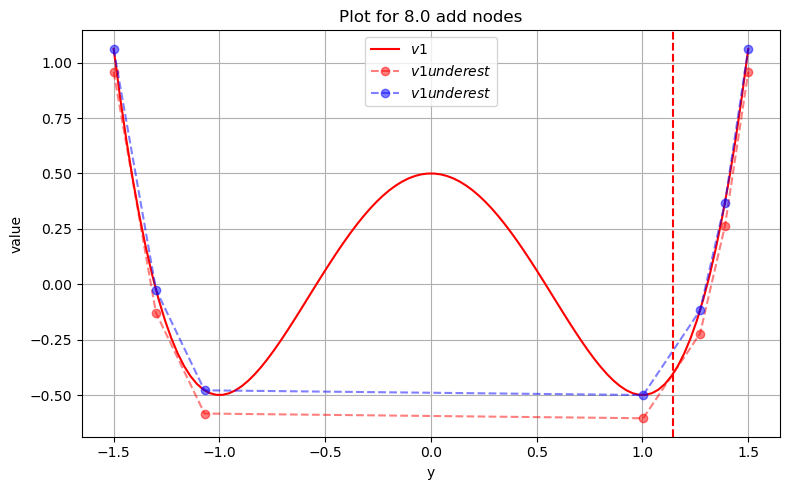

   
   
   
y node is  [-1.5        -1.29998354 -1.07041166  1.00320513  1.14457832  1.27204608
  1.38979233  1.5       ]
y node length 8
ms value is  [-0.09779493551599383, -0.09779493551599383]
new_nodes is  -1.4028540639474067
this time choose scenario  6


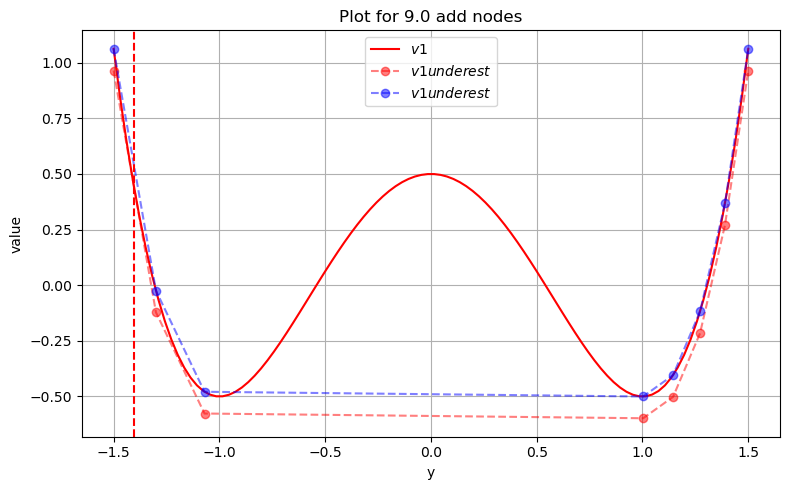

In [67]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x1 = Var(bounds=(0, 1))
m2.x11 = Var(bounds=(0, None))
m2.c1 = Constraint(expr=m2.x11**2 == m2.y**2)
m2.c2 = Constraint(expr=m2.x11 == (m2.x1)**2)
m2.obj_expr = Expression(expr=-m2.x1)

model_list = [m1]
# lower bound and upper bound
ylb = -0.2
yub = 0.2
bounds = [ylb, yub]

In [21]:
# make delta list
adds = np.arange(3, 8)
results = [nc_underest([ylb, yub],[m1,m2],a) for a in adds]

start
Start adding node  2
Solving scenario  0
Solving scenario  1
 
 
error is  0.8944271909999159
ms is  [0.0, 0.0] 0.0
 
 
new node choosen from error
 
new node is 0.0
ms list is [0.0, 0.0]
y_nodes is [-0.2, 0.0, 0.2]
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  0.22360681067697585
ms is  [-0.11180340533848798, -0.11180340533848798] 0.22360681067697596
 
 
new node choosen from ms
 
new node is -0.04998092776511266
ms list is [-0.11180340533848798, -0.11180340533848798]
y_nodes is [-0.2, 0.0, 0.2]
start
Start adding node  2
Solving scenario  0
Solving scenario  1
 
 
error is  0.8944271909999159
ms is  [0.0, 0.0] 0.0
 
 
new node choosen from error
 
new node is 0.0
ms list is [0.0, 0.0]
y_nodes is [-0.2, 0.0, 0.2]
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  0.22360681067697585
ms is  [-0.11180340533848798, -0.11180340533848798] 0.22360681067697596
 
 
new node choosen from ms
 
new node is -0.04998092776511266
ms list is

   
   
   
y node is  [-0.2  0.   0.2]
y node length 3
ms value is  [-0.11180340533848798, -0.11180340533848798]
new_nodes is  -0.04998092776511266
this time choose scenario  1


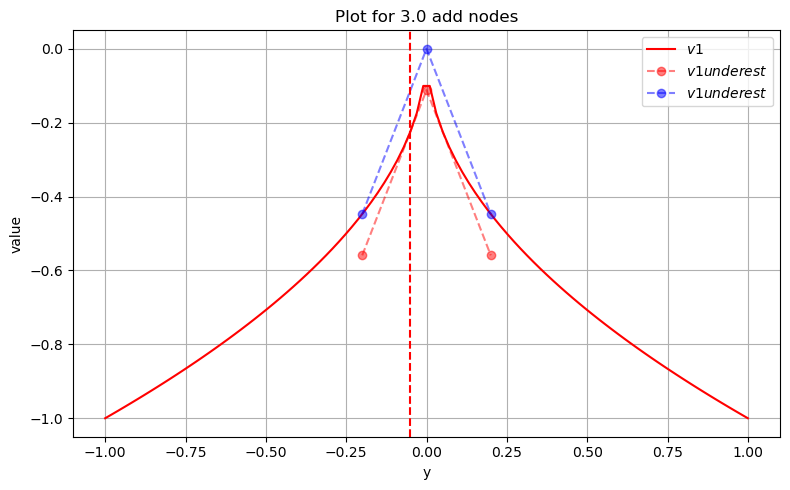

   
   
   
y node is  [-0.2        -0.04998093  0.          0.2       ]
y node length 4
ms value is  [-0.1118033669886418, -0.1118033669886418]
new_nodes is  0.04994661012497079
this time choose scenario  2


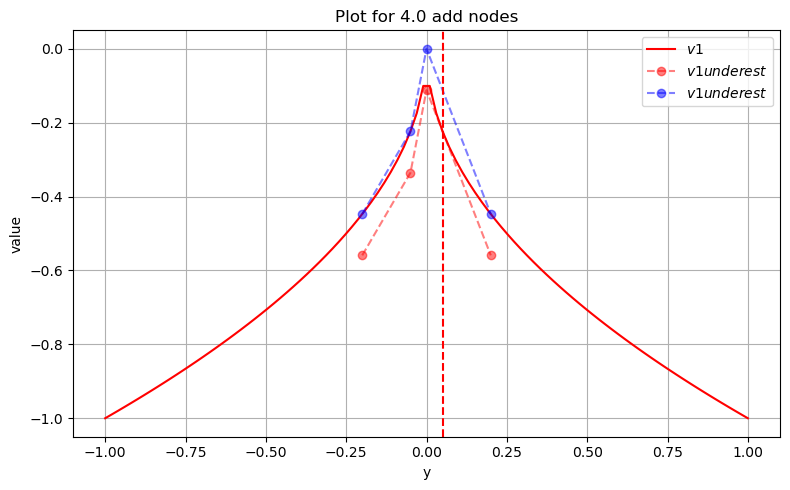

   
   
   
y node is  [-0.2        -0.04998093  0.          0.04994661  0.2       ]
y node length 5
ms value is  [-0.05589099986318791, -0.05589099986318791]
new_nodes is  -0.2
this time choose scenario  3


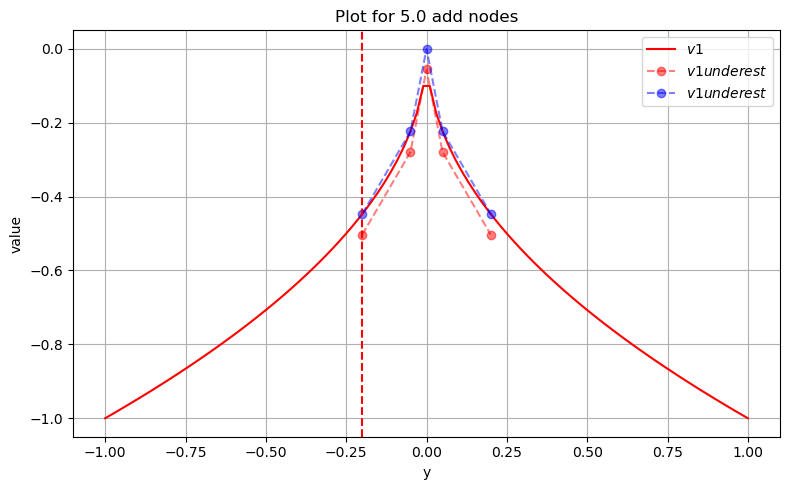

   
   
   
y node is  [-0.2        -0.04998093  0.          0.04994661  0.2       ]
y node length 5
ms value is  [-0.05589099986318791, -0.05589099986318791]
new_nodes is  -0.2
this time choose scenario  3


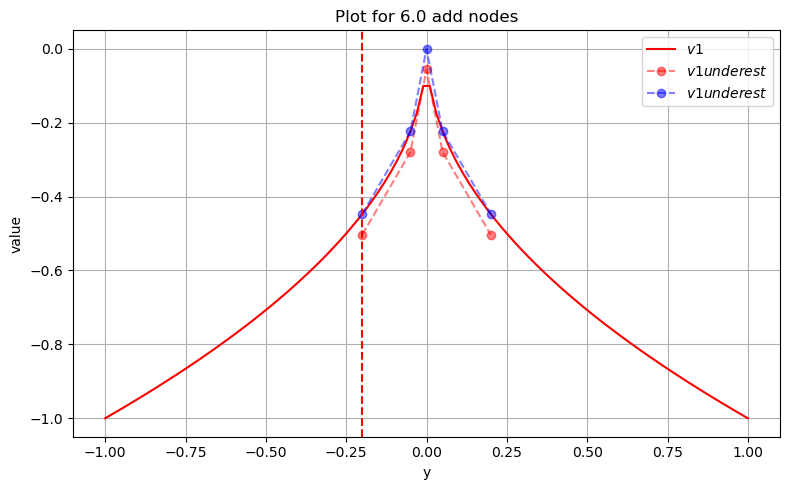

   
   
   
y node is  [-0.2        -0.04998093  0.          0.04994661  0.2       ]
y node length 5
ms value is  [-0.05589099986318791, -0.05589099986318791]
new_nodes is  -0.2
this time choose scenario  3


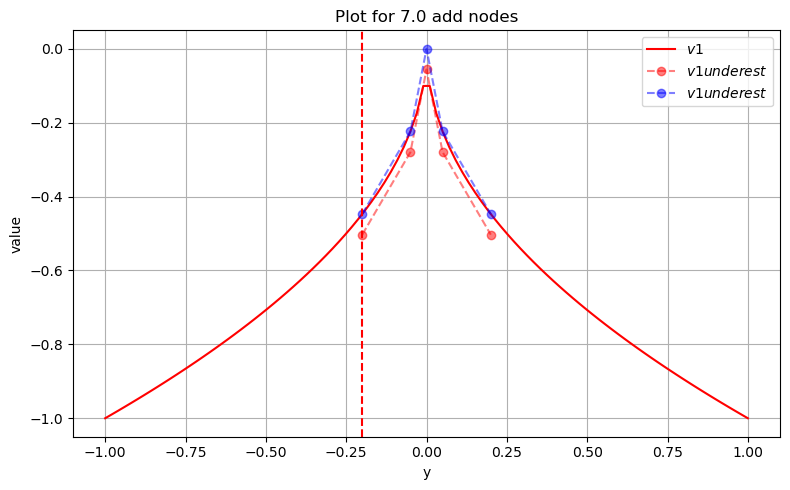

In [26]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
y_nodes = [-1, 1]
assum_nodes = [0,0]

model_sum = ConcreteModel()
model_sum.y = Var(bounds=(-1, 1))
model_sum.As = Var()
model_sum.pw = Piecewise(
    model_sum.As, model_sum.y,
    pw_pts=y_nodes,
    f_rule=list(assum_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2'
)
eps = 1e-6
model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
results = solver.solve(model_sum)


y_star = value(model_sum.y, exception=False)   
if y_star is None:
    y_star = 0.5*(lb + ub)
print(y_star)

NameError: name 'lb' is not defined

In [33]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [61]:
y_nodes = [-0.5,-0.1,0,0.5,1]
assum_nodes = [-1,-1,-1,-1,0]

model_sum = ConcreteModel()
model_sum.y = Var(bounds=(-1, 1))
model_sum.As = Var()
model_sum.pw = Piecewise(
    model_sum.As, model_sum.y,
    pw_pts=y_nodes,
    f_rule=list(assum_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2'
)
model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
results = solver.solve(model_sum)
y_star = value(model_sum.y)
print(y_star)

**WARNING: Piecewise 'pw[None]' feasible region does not include the lower bound of domain variable: y.lb = -1 < -0.5. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
-0.1


In [34]:
y_nodes = [-1, -0.5, 0.5, 1]
assum_nodes = [0,-1,-1,0]

model_sum = ConcreteModel()
model_sum.y = Var(bounds=(-1, 1))
model_sum.As = Var()
model_sum.pw = Piecewise(
    model_sum.As, model_sum.y,
    pw_pts=y_nodes,
    f_rule=list(assum_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2'
)
eps = 1e-6
model_sum.obj = Objective(expr = model_sum.As + eps*model_sum.y**2, sense=minimize)
results = solver.solve(model_sum)
y_star = value(model_sum.y)
print(y_star)

0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


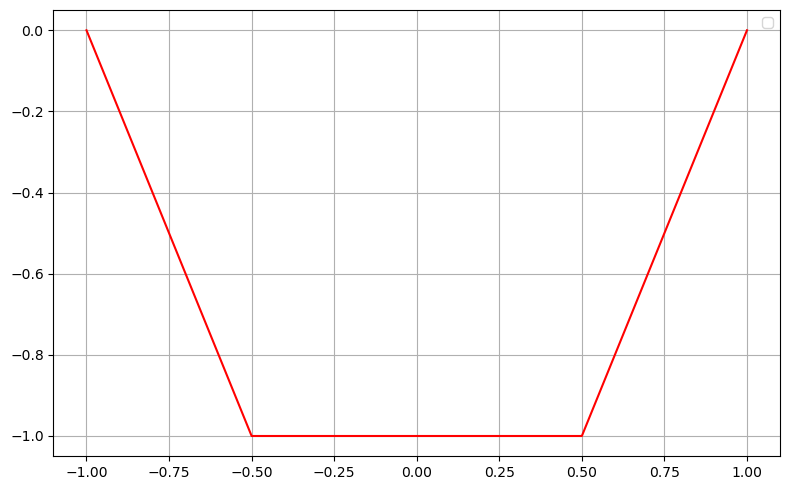

In [100]:
plt.figure(figsize=(8, 5))
plt.plot(y_nodes, assum_nodes, color='red')

plt.legend()
plt.grid(True)
plt.tight_layout()

In [82]:
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, Objective, Piecewise, minimize, value
from pyomo.opt import SolverFactory

# 倒梯形分段
y_nodes = [-1.0, -0.5, 0.0, 0.5, 1.0]
f_nodes =  [ 0.0, -1.0, -1.0,-1.0, 0.0]

m = ConcreteModel()
m.y  = Var(bounds=(-1, 1))
m.fy = Var()  # piecewise 输出

m.pw = Piecewise(
    m.fy, m.y,
    pw_pts=y_nodes,
    f_rule=list(f_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2',
    warn_consec_slope=False
)

# 极小的二级目标系数：只起到打破平局作用
eps = 1e-6
m.obj = Objective(expr = m.fy + eps*m.y**2, sense=minimize)

opt = SolverFactory('gurobi')
opt.options['Threads'] = 1      # 让结果可复现
res = opt.solve(m, tee=False)

print('y* =', value(m.y))       # -> 0.0（在底边内部）
print('f(y*) =', value(m.fy))   # -> -1.0

ValueError: Unexpected keyword options found while constructing 'SimplePiecewise':
	warn_consec_slope

In [83]:
m = ConcreteModel()
m.y  = Var(bounds=(-1, 1))
m.fy = Var()
m.t  = Var(bounds=(0, None))  # |y| 的上界变量

m.pw = Piecewise(
    m.fy, m.y,
    pw_pts=y_nodes, f_rule=list(f_nodes),
    pw_constr_type='EQ', pw_repn='SOS2',
    warn_consec_slope=False
)

# 把解限制在底边（函数最小值集合）
m.bottom = pyo.Constraint(expr = m.fy == -1)

# 线性地最小化 |y|： t >= y, t >= -y
m.abs1 = pyo.Constraint(expr = m.t >=  m.y)
m.abs2 = pyo.Constraint(expr = m.t >= -m.y)

m.obj = Objective(expr = m.t, sense=minimize)

opt = SolverFactory('gurobi')
opt.options['Threads'] = 1
res = opt.solve(m, tee=False)

print('y* =', value(m.y))      # -> 0.0
print('f(y*) =', value(m.fy))  # -> -1.0


ValueError: Unexpected keyword options found while constructing 'SimplePiecewise':
	warn_consec_slope